# 데이터 설정, 학습/검증 분리

In [39]:
import pandas as pd
import torch
import torch.nn.functional as F
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv, global_mean_pool
from torch_geometric.data import Data
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import joblib
import torch.nn as nn
from sklearn.utils import resample

# 1. 엣지 정의
edge_index = torch.tensor([
    [0,1, 1,2, 2,3, 3,7, 7,9, 9,11, 11,13, 13,15,
     2,4, 4,6, 6,8, 8,10, 10,12, 12,14, 14,16,
     2,17, 17,19, 19,21, 21,23, 23,25, 25,27,
     2,18, 18,20, 20,22, 22,24, 24,26, 26,28],
    [1,0, 2,1, 3,2, 7,3, 9,7, 11,9, 13,11, 15,13,
     4,2, 6,4, 8,6, 10,8, 12,10, 14,12, 16,14,
     17,2, 19,17, 21,19, 23,21, 25,23, 27,25,
     18,2, 20,18, 22,20, 24,22, 26,24, 28,26]
], dtype=torch.long)

# 2. CSV 불러오기 및 라벨 인코딩
df_etc = pd.read_csv('./data/train/csv_files/etc_landmarks_all.csv')
df_etc['class'] = 'etc'
df_sit = pd.read_csv('./data/train/csv_files/sit_landmarks_all.csv')
df_sit['class'] = 'sit'
df_stand = pd.read_csv('./data/train/csv_files/stand_landmarks_all.csv')
df_stand['class'] = 'stand'

df = pd.concat([df_etc, df_sit, df_stand], ignore_index=True)

le = LabelEncoder()
df['label'] = le.fit_transform(df['class'])

# 3. 클래스별 최소 수에 맞춰 이미지 단위 언더샘플링
df_img_level = df.groupby('image').first().reset_index()
min_count = df_img_level['label'].value_counts().min()

balanced_img_list = []
for label in df_img_level['label'].unique():
    df_label = df_img_level[df_img_level['label'] == label]
    sampled = resample(df_label, replace=False, n_samples=min_count, random_state=42)
    balanced_img_list.append(sampled)

df_balanced_img = pd.concat(balanced_img_list)
df_balanced = df[df['image'].isin(df_balanced_img['image'])].copy()

# 4. Data 객체 생성
def make_data_list(df):
    data_list = []
    images = df['image'].unique()
    for img in images:
        df_img = df[df['image'] == img].sort_values('id')
        x = df_img[['x','y','z']].values
        x = torch.tensor(x, dtype=torch.float)
        y = torch.tensor([df_img['label'].iloc[0]], dtype=torch.long)
        data = Data(x=x, edge_index=edge_index, y=y)
        data_list.append(data)
    return data_list

data_list = make_data_list(df_balanced)

# 5. 학습/검증 분리
train_data, val_data = train_test_split(data_list, test_size=0.2, random_state=42,
                                        stratify=[d.y.item() for d in data_list])
train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
val_loader = DataLoader(val_data, batch_size=16, shuffle=False)

# 모델 정의, 학습 세팅, 검증설정

In [40]:
# 6. GCN 모델 정의
class GCNNet(nn.Module):
    def __init__(self, in_channels=3, hidden_channels=128, num_classes=3):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.lin = nn.Linear(hidden_channels, num_classes)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        x = F.relu(self.conv3(x, edge_index))
        x = global_mean_pool(x, batch)
        out = self.lin(x)
        return out

# 7. 학습 세팅
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCNNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# 8. 학습 함수
def train_epoch():
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    for batch in train_loader:
        batch = batch.to(device)
        optimizer.zero_grad()
        out = model(batch)
        loss = criterion(out, batch.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * batch.num_graphs
        pred = out.argmax(dim=1)
        correct += (pred == batch.y).sum().item()
        total += batch.num_graphs
    return total_loss / total, correct / total

# 9. 검증 함수
def eval_epoch():
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for batch in val_loader:
            batch = batch.to(device)
            out = model(batch)
            loss = criterion(out, batch.y)
            total_loss += loss.item() * batch.num_graphs
            pred = out.argmax(dim=1)
            correct += (pred == batch.y).sum().item()
            total += batch.num_graphs
            all_preds.append(pred.cpu())
            all_labels.append(batch.y.cpu())
    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)
    return total_loss / total, correct / total, all_preds.numpy(), all_labels.numpy()

# 10. 학습 루프
num_epochs = 150
train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(1, num_epochs + 1):
    train_loss, train_acc = train_epoch()
    val_loss, val_acc, val_preds, val_labels = eval_epoch()

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    print(f"Epoch {epoch:03d} - Train loss: {train_loss:.4f}, Acc: {train_acc:.4f} | Val loss: {val_loss:.4f}, Acc: {val_acc:.4f}")

Epoch 001 - Train loss: 0.8741, Acc: 0.5760 | Val loss: 0.6905, Acc: 0.6939
Epoch 002 - Train loss: 0.5933, Acc: 0.7642 | Val loss: 0.5574, Acc: 0.7857
Epoch 003 - Train loss: 0.4931, Acc: 0.8212 | Val loss: 0.4804, Acc: 0.8214
Epoch 004 - Train loss: 0.4411, Acc: 0.8318 | Val loss: 0.4440, Acc: 0.8316
Epoch 005 - Train loss: 0.4146, Acc: 0.8455 | Val loss: 0.4081, Acc: 0.8435
Epoch 006 - Train loss: 0.3887, Acc: 0.8480 | Val loss: 0.4001, Acc: 0.8520
Epoch 007 - Train loss: 0.3895, Acc: 0.8455 | Val loss: 0.3800, Acc: 0.8537
Epoch 008 - Train loss: 0.3895, Acc: 0.8493 | Val loss: 0.4532, Acc: 0.8214
Epoch 009 - Train loss: 0.3564, Acc: 0.8621 | Val loss: 0.3805, Acc: 0.8537
Epoch 010 - Train loss: 0.3484, Acc: 0.8702 | Val loss: 0.3586, Acc: 0.8656
Epoch 011 - Train loss: 0.3518, Acc: 0.8646 | Val loss: 0.3575, Acc: 0.8690
Epoch 012 - Train loss: 0.3436, Acc: 0.8676 | Val loss: 0.3529, Acc: 0.8690
Epoch 013 - Train loss: 0.3386, Acc: 0.8659 | Val loss: 0.3501, Acc: 0.8776
Epoch 014 - 

# 저장 및 시각화


[Classification Report]
              precision    recall  f1-score   support

         etc       0.95      0.97      0.96       196
         sit       0.90      0.89      0.90       196
       stand       0.91      0.89      0.90       196

    accuracy                           0.92       588
   macro avg       0.92      0.92      0.92       588
weighted avg       0.92      0.92      0.92       588



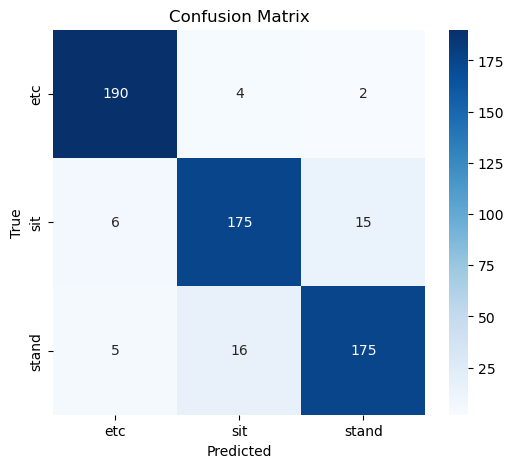

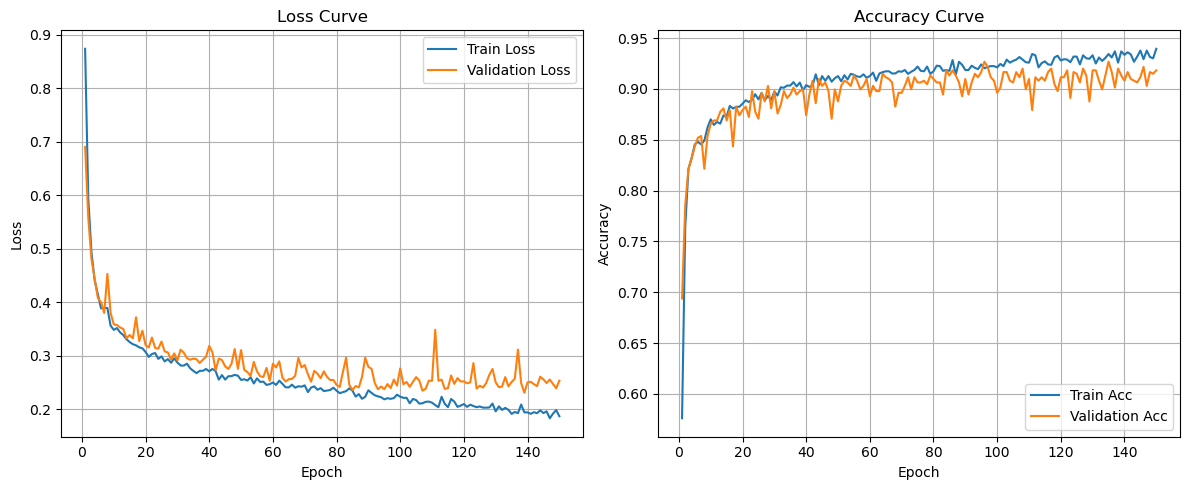

In [ ]:
# 11. 학습 완료 후 모델과 LabelEncoder 저장
torch.save(model.state_dict(), 'best_gcn_model.pth')
joblib.dump(le, 'label_encoder.pkl')
torch.save(data_list, 'data_list.pt')

# 12. 최종 평가 및 리포트 출력
model.load_state_dict(torch.load('best_gcn_model.pth'))
model.eval()

_, _, val_preds, val_labels = eval_epoch()
print("\n[Classification Report]")
print(classification_report(val_labels, val_preds, target_names=le.classes_))

# 13. 혼동행렬 시각화
cm = confusion_matrix(val_labels, val_preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# 14. 손실, 정확도 그래프 출력
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(range(1,len(train_losses)+1), train_losses, label='Train Loss')
plt.plot(range(1,len(val_losses)+1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()
plt.grid()

plt.subplot(1,2,2)
plt.plot(range(1,len(train_accs)+1), train_accs, label='Train Acc')
plt.plot(range(1,len(val_accs)+1), val_accs, label='Validation Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

# 분포도에 이미지 이름 추가 출력

/Users/skoo/miniforge3/envs/tf_m3/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 4359 (\N{HANGUL CHOSEONG PIEUP}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/skoo/miniforge3/envs/tf_m3/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 4457 (\N{HANGUL JUNGSEONG O}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/skoo/miniforge3/envs/tf_m3/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 4520 (\N{HANGUL JONGSEONG KIYEOK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/skoo/miniforge3/envs/tf_m3/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 4361 (\N{HANGUL CHOSEONG SIOS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/skoo/miniforge3/envs/tf_m3/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 4

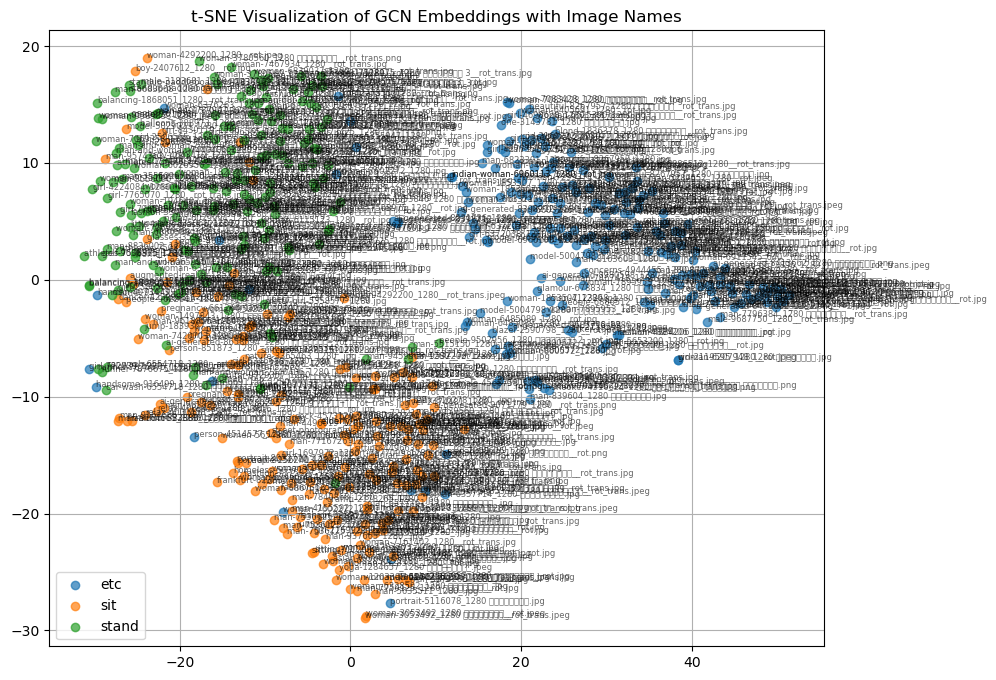

In [21]:
def make_data_list_with_names(df):
    data_list = []
    image_names = []
    images = df['image'].unique()
    for img in images:
        df_img = df[df['image'] == img].sort_values('id')
        x = df_img[['x','y','z']].values
        x = torch.tensor(x, dtype=torch.float)
        y = torch.tensor([df_img['label'].iloc[0]], dtype=torch.long)
        data = Data(x=x, edge_index=edge_index, y=y)
        data_list.append(data)
        image_names.append(img)  # 이미지명 저장
    return data_list, image_names

# 사용 예
data_list, image_names = make_data_list_with_names(df)

# 학습/검증 분리 시
from sklearn.model_selection import train_test_split

labels = [d.y.item() for d in data_list]
train_data, val_data, train_names, val_names = train_test_split(
    data_list, image_names, test_size=0.2, random_state=42, stratify=labels)

# 이후 tsne 함수 호출 시 val_names를 img_names 인자로 넘기면 됨
tsne_visualization_with_imgname(model, val_data, le, device, val_names)

# 오류 체크 및 점수 평가

총 오분류 샘플 수: 48
Index: 0, Image: man-and-woman-7440406_1280 복사본.jpg, True: stand, Predicted: sit
Index: 1, Image: cute-1430236_1280 복사본_.jpg, True: sit, Predicted: stand
Index: 4, Image: cute-1430236_1280 복사본_.jpg, True: sit, Predicted: etc
Index: 18, Image: cute-1430236_1280 복사본_.jpg, True: sit, Predicted: stand
Index: 25, Image: cute-1430236_1280 복사본_.jpg, True: sit, Predicted: stand
Index: 49, Image: man-and-woman-7440406_1280 복사본.jpg, True: stand, Predicted: etc
Index: 71, Image: man-and-woman-7440406_1280 복사본.jpg, True: stand, Predicted: sit
Index: 76, Image: cute-1430236_1280 복사본_.jpg, True: sit, Predicted: etc
Index: 93, Image: cute-1430236_1280 복사본_.jpg, True: sit, Predicted: stand
Index: 121, Image: man-and-woman-7440406_1280 복사본.jpg, True: stand, Predicted: etc


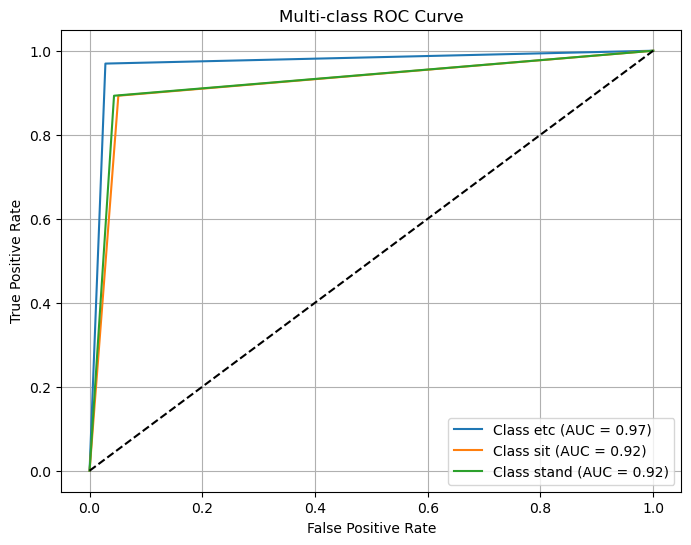

etc: 총 196개 중 오분류 6개 (3.06%)
  - sit로 오분류: 4개
  - stand로 오분류: 2개
sit: 총 196개 중 오분류 21개 (10.71%)
  - etc로 오분류: 6개
  - stand로 오분류: 15개
stand: 총 196개 중 오분류 21개 (10.71%)
  - etc로 오분류: 5개
  - sit로 오분류: 16개


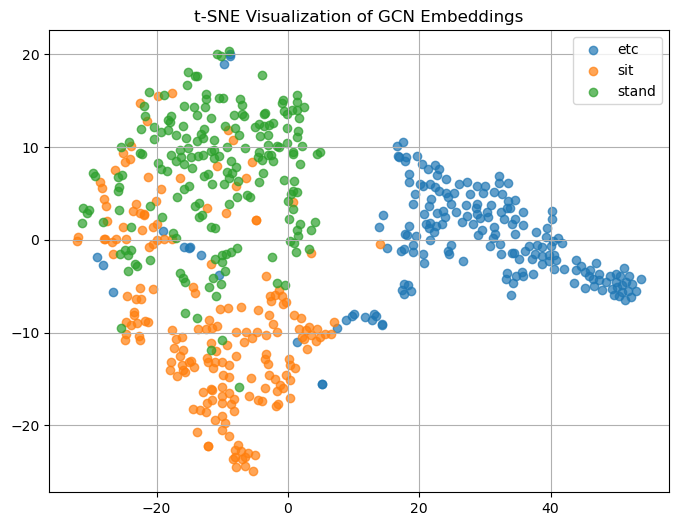

In [ ]:
import numpy as np
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# --- 1. 오분류 샘플 출력 ---
def print_misclassified_samples(val_preds, val_labels, df):
    mis_idx = np.where(val_preds != val_labels)[0]
    print(f"총 오분류 샘플 수: {len(mis_idx)}")
    for idx in mis_idx[:10]:  # 상위 10개만 출력
        true_label = le.classes_[val_labels[idx]]
        pred_label = le.classes_[val_preds[idx]]
        # 이미지명(df['image']) 참고
        img_name = df[df['label'] == val_labels[idx]].iloc[0]['image'] if 'image' in df.columns else 'N/A'
        print(f"Index: {idx}, Image: {img_name}, True: {true_label}, Predicted: {pred_label}")

# --- 2. 다중 클래스 ROC-AUC 시각화 ---
def plot_multiclass_roc(val_labels, val_preds, num_classes=3):
    val_labels_bin = label_binarize(val_labels, classes=range(num_classes))
    val_preds_bin = label_binarize(val_preds, classes=range(num_classes))
    
    plt.figure(figsize=(8,6))
    for i in range(num_classes):
        fpr, tpr, _ = roc_curve(val_labels_bin[:, i], val_preds_bin[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'Class {le.classes_[i]} (AUC = {roc_auc:.2f})')
    plt.plot([0,1],[0,1],'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Multi-class ROC Curve')
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()

# --- 3. 혼동행렬 상세 분석 ---
def confusion_error_analysis(cm, classes):
    for i, cls in enumerate(classes):
        total = np.sum(cm[i])
        correct = cm[i,i]
        errors = total - correct
        print(f"{cls}: 총 {total}개 중 오분류 {errors}개 ({errors/total*100:.2f}%)")
        for j, other_cls in enumerate(classes):
            if j != i and cm[i,j] > 0:
                print(f"  - {other_cls}로 오분류: {cm[i,j]}개")

# --- 4. t-SNE 임베딩 시각화 ---
def tsne_visualization(model, data_list, le, device):
    model.eval()
    embeddings = []
    labels = []
    with torch.no_grad():
        for data in data_list:
            data = data.to(device)
            batch = data.batch if hasattr(data, 'batch') else torch.zeros(data.num_nodes, dtype=torch.long).to(device)
            x = F.relu(model.conv1(data.x, data.edge_index))
            x = F.relu(model.conv2(x, data.edge_index))
            pooled = global_mean_pool(x, batch)
            embeddings.append(pooled.cpu().numpy())
            labels.append(data.y.item())
    embeddings = np.vstack(embeddings)
    labels = np.array(labels)

    tsne = TSNE(n_components=2, random_state=42)
    emb_2d = tsne.fit_transform(embeddings)

    plt.figure(figsize=(8,6))
    for label_idx in np.unique(labels):
        idxs = labels == label_idx
        plt.scatter(emb_2d[idxs,0], emb_2d[idxs,1], label=le.classes_[label_idx], alpha=0.7)
    plt.legend()
    plt.title('t-SNE Visualization of GCN Embeddings')
    plt.grid()
    plt.show()

print_misclassified_samples(val_preds, val_labels, df)

plot_multiclass_roc(val_labels, val_preds, num_classes=len(le.classes_))

confusion_error_analysis(cm, le.classes_)

tsne_visualization(model, val_data, le, device)